In [32]:
pip install tensorflow-datasets 

Note: you may need to restart the kernel to use updated packages.


In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [34]:
# loading the dataset
data, data_info = tfds.load('malaria',as_supervised=True,split='train',with_info=True,shuffle_files=True)

In [35]:
data_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Atharva Darke\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      im

In [36]:
list(data.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

In [37]:
# Splitting the dataset:-
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1


In [38]:
def split(dataset,TRAIN_RATIO,TEST_RATIO,VAL_RATIO):
    DATA_SIZE = len(data)
    train_dataset = data.take(int(TRAIN_RATIO*DATA_SIZE))
    test_ = data.skip(int(TRAIN_RATIO*DATA_SIZE))
    test_dataset = test_.take(int(TEST_RATIO*DATA_SIZE))
    valid_dataset = test_.skip(int(TEST_RATIO*DATA_SIZE))
    return train_dataset,test_dataset,valid_dataset

In [39]:
train,test,valid = split(data,TRAIN_RATIO,TEST_RATIO,VAL_RATIO)

In [40]:
print(len(data),len(train),len(test),len(valid))

27558 22046 2755 2757


In [41]:
print(list(train.take(1).as_numpy_iterator()),list(test.take(1).as_numpy_iterator()),list(valid.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

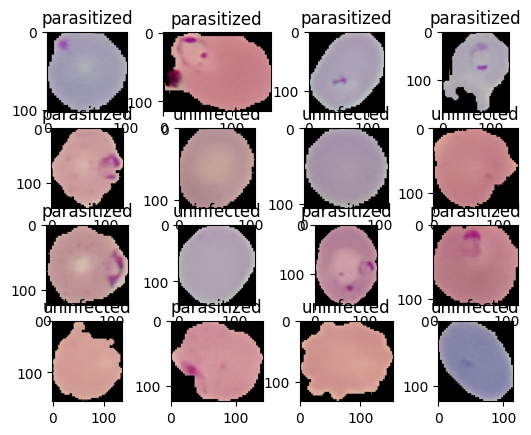

In [42]:
# visualizing the data
import matplotlib.pyplot as plt

for i,(image,label) in enumerate(train.take(16)):
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(data_info.features['label'].int2str(label))

In [43]:
# Preprocessing:

def preprocess(image,label):
    image_resized = tf.image.resize(image,size=(224,224),method='bilinear')/255.0
    return image_resized,label

In [44]:
train = train.map(preprocess)
valid = valid.map(preprocess)
test = test.map(preprocess)

train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

In [45]:
train.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [46]:
data_info.features['label']

ClassLabel(shape=(), dtype=int64, num_classes=2)

In [47]:
for image,label in test.take(1):
    print(image)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [48]:
for item in train.take(1):
    print(type(item))

<class 'tuple'>


In [49]:
for image,label in train.take(1):
    print(image.shape,label.shape)

(32, 224, 224, 3) (32,)


In [50]:
model = tf.keras.Sequential([
                            InputLayer(shape=(224,224,3)),
                            Conv2D(filters=6,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=(2,2),strides=2),

                            Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=(2,2),strides=2),

                            Flatten(),

                            layers.Dense(100,activation='relu'),
                            BatchNormalization(),

                            layers.Dense(10,activation='relu'),
                            BatchNormalization(),
                            layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [51]:
len(valid)

87

In [52]:
list(data.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

In [53]:
early_call = EarlyStopping(min_delta=0.01,verbose=1,patience=10)

In [54]:
#
model.compile(optimizer=Adam(learning_rate=0.01),metrics=['accuracy'],loss=BinaryCrossentropy())

In [55]:
history = model.fit(train,validation_data=valid,batch_size=50,epochs=5,verbose=1, callbacks=[early_call])

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 285s 404ms/step - accuracy: 0.7611 - loss: 0.4945 - val_accuracy: 0.8299 - val_loss: 0.4504
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 279s 405ms/step - accuracy: 0.9071 - loss: 0.2564 - val_accuracy: 0.6471 - val_loss: 0.4844
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 277s 402ms/step - accuracy: 0.9235 - loss: 0.2178 - val_accuracy: 0.9184 - val_loss: 0.2431
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 281s 408ms/step - accuracy: 0.9358 - loss: 0.1801 - val_accuracy: 0.5169 - val_loss: 0.7359
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 316s 399ms/step - accuracy: 0.9478 - loss: 0.1572 - val_accuracy: 0.8694 - val_loss: 1.0373


In [56]:
# saving the model in keras format i.e HDF5(.h5) format. This saves the entire structure of the model i.e the configurations as well as the weights
model.save("lenet_model.keras")
model.save("lenet_model.h5")

In [76]:
eval = model.evaluate(test)

87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8840 - loss: 1.4395


In [61]:
preds = model.predict(test.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [62]:
def diagnosed_or_not(x):
    if x>=0.5:
        return str("diagnosed")

    else:
        return str("not_diagnosed")
    


    

In [63]:
diagnosed_or_not(preds)

'diagnosed'

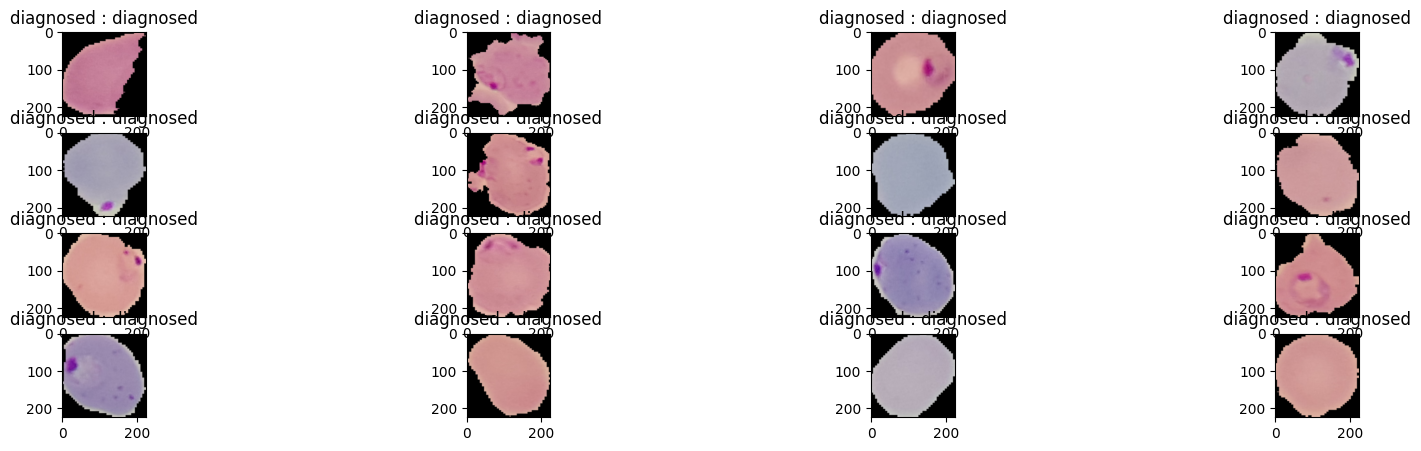

In [91]:
plt.figure(figsize=(20,5))
for i,(image,label) in enumerate(test.take(1)):
    for j in range(16):
        axes = plt.subplot(4,4,j+1)
        plt.imshow(image[j])
        plt.title(str(diagnosed_or_not(label.numpy()[0])) +" : "+ str(diagnosed_or_not(preds)))
    # print(image[0][0])